# Multiclass Classification

In this very brief tutorial, we aim to explain the idea of creating a **Multiclass Classification Model**.

## General Setup

In [1]:
import torch                # Model creation       
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_classification     # General dataset creation
from sklearn.model_selection import train_test_split # Splitting the dataset into train and test part
from sklearn.preprocessing   import StandardScaler   # Rescaling the dataset, explained down below

import matplotlib.pyplot as plt # Plotting

It is useful to understand, from beginning, what device to use - will PyTorch data be loaded and trained on the GPU, or the CPU.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/lukan123/Desktop/pytorch-algo-impl/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Dataset Creation

Even though a very popular approach to creating a dataset for binary classification task is to use a **two moon dataset**, for the purposes of **MULTIclass** classification task, we will create a synthetic classification dataset of **5 classes** to predict from. To remember:

`N_SAMPLES` is the total number of samples we will use in this model's testing and training. We will split that later on into respective parts.

`N_FEATURES` is the number representing how many values describe our sample. If we have `N_FEATURES = 2`, that means 2 values describe a  single sample, i.e. it is mapped into a 2-dimensional space. We will use only 2 features per sample for the sake of **visualization** (higher dimensions are higher to present meaningfully).

`N_CLASSES` is the number of classes we are predicting from. In this particular case, it is `3`.

In [3]:
# General data settings
N_SAMPLES     = 1000
N_CLASSES     = 3
N_CLUSTERS_PC = 1
N_FEATURES    = 2
N_INFORMATIVE = 2
N_REDUNDANT   = 0

Generate both features (`X`) and labels (i.e. classes, `y`). We will use the aforementioned constants for configuring the dataset.

In [4]:
X, y = make_classification(n_samples=N_SAMPLES,
                           n_classes=N_CLASSES,
                           n_clusters_per_class=N_CLUSTERS_PC,
                           n_features=N_FEATURES,
                           n_informative=N_INFORMATIVE,
                           n_redundant=N_REDUNDANT,
                           random_state=42,
                           )

Naturally, we wish to use some data for training, and some data to be left for testing (i.e. *unseen*), so we check how model generalizes.

We will perform a standard 80% (`training`) - 20% (`test`) split.

In [5]:
# This will split original dataset of 1000 samples into 20% test (i.e. 200 samples), and 80% train (i.e. 800 samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the sake of data exploration, we can visualize it:

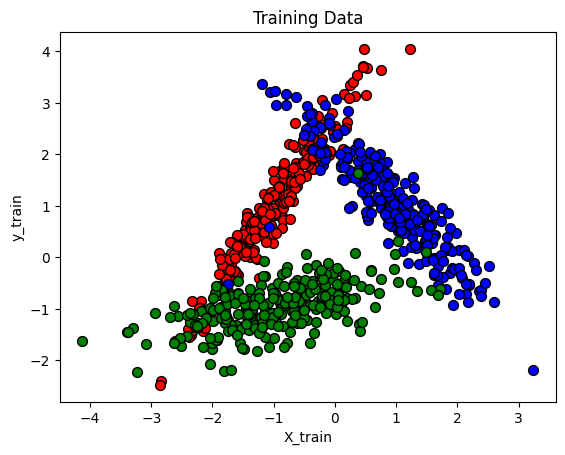

<Figure size 800x600 with 0 Axes>

In [6]:
X_train_class_0 = X_train[y_train == 0] # Get all the training samples whose class, i.e. `y`, equals 0 
X_train_class_1 = X_train[y_train == 1] # Get all the training samples whose class, i.e. `y`, equals 1
X_train_class_2 = X_train[y_train == 2] # Get all the training samples whose class, i.e. `y`, equals 2

# Scatter given samples in two different colors - red for class `0`, and blue for class `1`
plt.scatter(X_train_class_0[:, 0], X_train_class_0[:, 1], color='red',   label="Class 0", edgecolor="k", s=50)
plt.scatter(X_train_class_1[:, 0], X_train_class_1[:, 1], color='blue',  label="Class 1", edgecolor="k", s=50)
plt.scatter(X_train_class_2[:, 0], X_train_class_2[:, 1], color='green', label="Class 2", edgecolor="k", s=50)

# General plotting settings
plt.title("Training Data") # Plot title
plt.xlabel("X_train")      # X-axis label
plt.ylabel("y_train")      # Y-axis label
plt.figure(figsize=(8, 6)) # Figure size

plt.show() # Finally, show the plot

Don't forget to convert data to `tensors`(used by PyTorch) and place them on the relevant device - `device` stores whether we use CPU or GPU.

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test,  dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test  = torch.tensor(y_test,  dtype=torch.long).to(device)

Now that dataset is ready, we can proceed onto model creation.

## Model Implementation

In [8]:
class MulticlassRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        """Constructor method
        
        Using inheritance of torch.nn.Module, MulticlassRegressionModel is created.
        
        Args:
            input_size  (int): the number of input values
            output_size (int): the number of output values
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size) # Applying standard linear transformation (f(x) = W * X + B) 
        
    def forward(self, X):
        """Forward pass 
    
        Based on current value of "W", calculate the prediction for each value of "X".
        
        Args:
            X (torch.Tensor): The values used for making prediction based on current state of "w" and "b"

        Returns:
            out (torch.Tensor): Model evaluation for given input
        """
        out = self.linear(X)            # Function is a simple linear equation: f(X) = W * X + B. Dimension: [SAMPLES x N_CLASSES]
        out = torch.softmax(out, dim=1) # All probabilities add to 1
        
        return out

We have a single linear layer that applies the standard transformation of multiplying the input with weight matrix, and adding the biases.

To remember, input is of shape `SAMPLES` x `N_FEATURES`, where `SAMPLES` is the number of training samples (in our respective case, `80% * N_SAMPLES = 800`) and `N_FEATURES = 2`. 

Because of matrix multiplication rules, the number of **rows** in the **weight** matrix will be equal to `N_FEATURES`, whereas the number of **columns** in the **weight** matrix will be number of the output values, i.e. `N_CLASSES` because we are predicting the probability of the sample being of respective class. So, the shape of the **weight** matrix is: `N_FEATURES` x `N_CLASSES`.

Create the model:

In [9]:
model = MulticlassRegressionModel(N_FEATURES, N_CLASSES).to(device)

## Training the Model

Standard loss function for the multiclass classification problem is **Cross Entropy Loss**.

In [10]:
criterion = nn.CrossEntropyLoss()

Optimizer can be experimented with - for the sake of simplicity, we choose **Adam**.

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

We will train our model for `10,000` epochs. This won't last too long simply because dataset is small.

In [12]:
epochs = 10_000

In [13]:
for epoch in range(epochs):
    model.train()

    y_predictions = model(X_train)
    
    # Calculate the loss between the predictions made, and the actual values
    loss = criterion(y_predictions, y_train)

    # Perform a backward pass
    optimizer.zero_grad() # Do not accumulate the gradient
    loss.backward()       # Do a back propagation setp
    optimizer.step()      # Optimize the weights

    if epoch % 100 == 0:
        # Print the data
        print("Epoch: {}, \tLoss: {}".format(epoch, loss.item()))

Epoch: 0, 	Loss: 1.1923832893371582
Epoch: 100, 	Loss: 1.135554313659668
Epoch: 200, 	Loss: 1.0696176290512085
Epoch: 300, 	Loss: 1.009110689163208
Epoch: 400, 	Loss: 0.9619076251983643
Epoch: 500, 	Loss: 0.9254626631736755
Epoch: 600, 	Loss: 0.8959890604019165
Epoch: 700, 	Loss: 0.8712053894996643
Epoch: 800, 	Loss: 0.8499685525894165
Epoch: 900, 	Loss: 0.8316819071769714
Epoch: 1000, 	Loss: 0.8159360289573669
Epoch: 1100, 	Loss: 0.8023687601089478
Epoch: 1200, 	Loss: 0.790641725063324
Epoch: 1300, 	Loss: 0.7804516553878784
Epoch: 1400, 	Loss: 0.7715386748313904
Epoch: 1500, 	Loss: 0.7636879682540894
Epoch: 1600, 	Loss: 0.7567245364189148
Epoch: 1700, 	Loss: 0.7505074143409729
Epoch: 1800, 	Loss: 0.7449223399162292
Epoch: 1900, 	Loss: 0.7398775219917297
Epoch: 2000, 	Loss: 0.7352972626686096
Epoch: 2100, 	Loss: 0.7311195135116577
Epoch: 2200, 	Loss: 0.7272930145263672
Epoch: 2300, 	Loss: 0.7237746715545654
Epoch: 2400, 	Loss: 0.7205284833908081
Epoch: 2500, 	Loss: 0.7175238728523254
E

Up there we can see the **training loss**, and now we will inspect how our model generalizes onto the unseen data, i.e. **test accuracy**.

In [14]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_test_predictions       = model(X_test).round()
    sample_class_predictions = torch.argmax(y_test_predictions, dim=1)
    
    test_accuracy      = (sample_class_predictions.eq(y_test).sum().float() / y_test.shape[0]).item()

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 85.50%
